In [39]:
import pandas as pd

In [40]:
##Load DataSets
team_stats = pd.read_csv("DEV _ March Madness Fixed.csv")
game_results = pd.read_csv("Game History Fixed.csv")

In [41]:
##Merge team stats from DEV file with Winning teams from Game History file (Merged based on team name)
winners = game_results.merge(
    team_stats,
    left_on=['Season', 'W TEAM'],
    right_on=['Season', 'Mapped ESPN Team Name'],
    how="left"  # Keep all tournament games, add matching team stats
)
winners['Win'] = 1  # Mark wins

In [42]:
##Merge team stats from DEV file with Losing teams from Game History file (Merged based on team name)
losers = game_results.merge(
    team_stats,
    left_on=['Season', 'L TEAM'],
    right_on=['Season', 'Mapped ESPN Team Name'],
    how="left"
)
losers['Win'] = 0  # Mark losses

In [43]:
##Concatenate winners and losers into a single file (new row for each team in each game)
merged_data = pd.concat([winners, losers], ignore_index=True)

# Now, **add back 2025 team stats**, ensuring they stay in the final dataset
merged_data = pd.concat([merged_data, team_stats[team_stats["Season"] == 2025]], ignore_index=True)

merged_data = merged_data[merged_data["Season"] >= 2008]

In [44]:
##Export File as CSV
merged_data.to_csv("merged_MM_data.csv", index=False)

In [45]:
##Define Tournament Rounds
tournament_rounds = {0: "First Four", 1 : "Round of 64", 2 : "Round of 32", 3 : "Sweet 16", 4 : "Elite 8", 5: "Final 4", 6 : "National Championship"}

In [46]:
# Replace NaN in "Round" with -1 (indicating no tournament round played)
merged_data["Round"] = merged_data["Round"].fillna(-1).astype(int)


##make sure "Round" is an integer
merged_data["Round"] = merged_data["Round"].astype(int)

##find max round each team reached in a given season
team_ceiling = merged_data.groupby(['Season', 'Mapped ESPN Team Name'])['Round'].max().reset_index()

##rename column
team_ceiling.rename(columns={"Round": 'Max_Round_Reached'}, inplace=True)

##merge back into dataset
merged_data = merged_data.merge(team_ceiling, on=['Season', 'Mapped ESPN Team Name'], how='left')

##Save to csv for observation
merged_data.to_csv("Merged_data_with_Team_Ceilings.csv", index=False)

In [47]:
##Display the data set with round advancements
print(merged_data[['Season', "Mapped ESPN Team Name", 'Round', 'Max_Round_Reached']].drop_duplicates())

      Season     Mapped ESPN Team Name  Round  Max_Round_Reached
0       2008          Mount St. Mary's      0                1.0
1       2009            Morehead State      0                1.0
2       2010            Morehead State      0                0.0
3       2011                   Clemson      0                1.0
4       2011             UNC Asheville      0                1.0
...      ...                       ...    ...                ...
2484    2025               Alabama A&M     -1               -1.0
2485    2025              Coppin State     -1               -1.0
2486    2025             Chicago State     -1               -1.0
2487    2025       Arkansas-Pine Bluff     -1               -1.0
2488    2025  Mississippi Valley State     -1               -1.0

[2464 rows x 4 columns]


In [48]:
##Add in Round Names as a new column
merged_data["Round_Name"] = merged_data["Round"].map(tournament_rounds)
merged_data["Max_Round_Reached_Name"] = merged_data["Max_Round_Reached"].map(tournament_rounds)

In [49]:
merged_data.to_csv("Updated & Merged Data.csv", index=False)

In [50]:
print(merged_data[['Season', 'Mapped ESPN Team Name', 'Max_Round_Reached_Name']].drop_duplicates())

      Season     Mapped ESPN Team Name Max_Round_Reached_Name
0       2008          Mount St. Mary's            Round of 64
1       2009            Morehead State            Round of 64
2       2010            Morehead State             First Four
3       2011                   Clemson            Round of 64
4       2011             UNC Asheville            Round of 64
...      ...                       ...                    ...
2484    2025               Alabama A&M                    NaN
2485    2025              Coppin State                    NaN
2486    2025             Chicago State                    NaN
2487    2025       Arkansas-Pine Bluff                    NaN
2488    2025  Mississippi Valley State                    NaN

[1442 rows x 3 columns]


In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

In [52]:
##Read the new file
merged_data = pd.read_csv("Updated & Merged Data.csv")

In [53]:
##Select only numeric collumns (we want to find correlations between deep runs and certain team stats)
merged_data["Max_Round_Reached"] = merged_data["Max_Round_Reached"].astype(float)

numeric_columns = merged_data.select_dtypes(include=['number'])

##remove "round", "win" & "daynum" from analysis as it will have near perfect correlation and isnt a 'stat'
numeric_columns = numeric_columns.drop(columns=["Round"], errors="ignore")
numeric_columns = numeric_columns.drop(columns=["DayNum"], errors="ignore")
numeric_columns = numeric_columns.drop(columns=["Win"], errors="ignore")


In [54]:
##Find & Sort correlations
correlations = numeric_columns.corr()["Max_Round_Reached"].drop("Max_Round_Reached")

correlations = correlations.sort_values(ascending=False)

In [55]:
print(correlations.head(15))
print(correlations.tail(15))

AdjEM                            0.731946
Net Rating                       0.731907
Adjusted Offensive Efficiency    0.587842
AdjOE                            0.586965
Raw Offensive Efficiency         0.431552
OE                               0.431423
ORPct                            0.317392
EffectiveHeight                  0.316000
FG3Pct                           0.289281
CenterHeight                     0.283738
eFGPct                           0.282766
OppNSTRate                       0.265555
PFHeight                         0.257345
BlockPct                         0.249853
SFHeight                         0.226098
Name: Max_Round_Reached, dtype: float64
RankDE                                 -0.455165
OppFG2Pct                              -0.470152
DE                                     -0.529716
Raw Defensive Efficiency               -0.529929
RankOE                                 -0.549054
Raw Offensive Efficiency Rank          -0.549054
Post-Season Tournament Sorting Index

/tmp/ipykernel_2643/4231976441.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlations.head(15).values, y=correlations.head(15).index, palette="coolwarm")


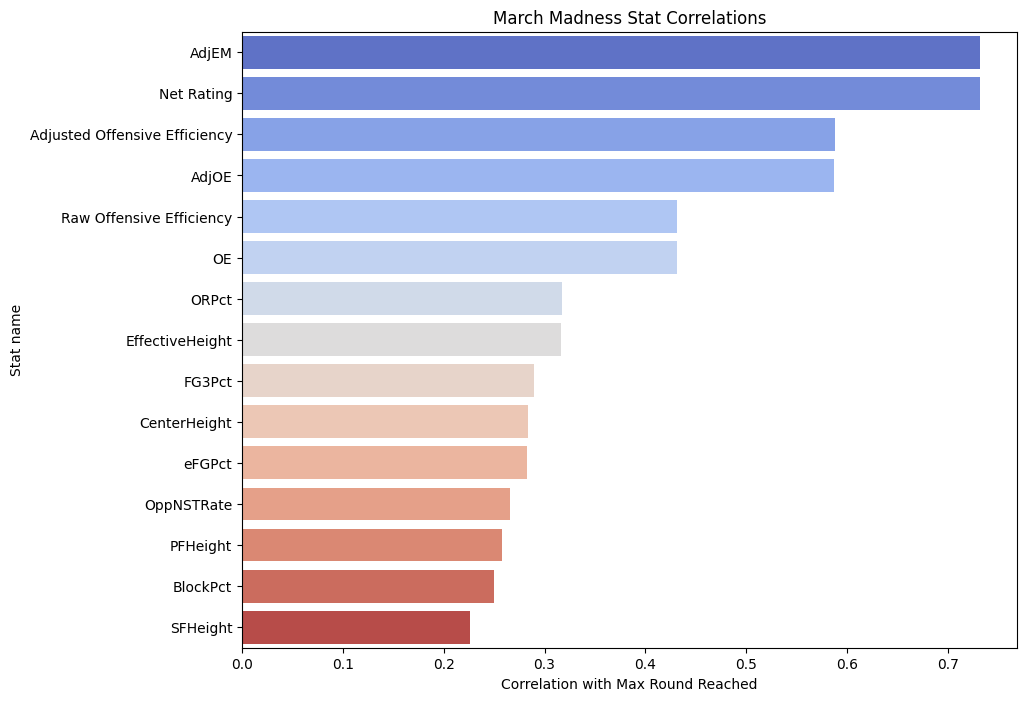

In [56]:
plt.figure(figsize=(10, 8))
sns.barplot(x=correlations.head(15).values, y=correlations.head(15).index, palette="coolwarm")
plt.xlabel("Correlation with Max Round Reached")
plt.ylabel("Stat name")
plt.title("March Madness Stat Correlations")
plt.show()

In [57]:
# Filter only the championship game
championship_games = merged_data[merged_data["Round"] == 6]

# Keep only the winning team from the championship
champions = championship_games[championship_games["Win"] == 1]

# Select relevant columns
champion_stats = champions[["Season", "W TEAM", "Net Rating", "AdjEM", "AdjOE"]]

# Sort by season
champion_stats = champion_stats.sort_values(by="Season", ascending=True)

# Rename for clarity
champion_stats.rename(columns={"W TEAM": "Champion"}, inplace=True)

# Display the past champions’ stats
print(champion_stats)

      Season        Champion  Net Rating    AdjEM    AdjOE
1046    2008          Kansas        35.2  35.2083  120.873
1047    2009  North Carolina        31.1  31.1390  123.248
1048    2010            Duke        33.3  33.2863  121.003
1049    2011           UConn        23.9  23.9329  115.846
1050    2012        Kentucky        32.6  32.5881  122.182
1051    2013      Louisville        32.9  32.9166  117.680
1052    2014           UConn        22.1  22.1300  113.591
1053    2015            Duke        32.5  32.4841  124.454
1054    2016       Villanova        32.0  32.0092  122.761
1055    2017  North Carolina        28.2  28.2180  120.675
1056    2018       Villanova        33.8  33.7563  127.756
1057    2019        Virginia        34.2  34.2156  123.403
1058    2021          Baylor        33.9  33.8670  124.994
1059    2022          Kansas        27.5  27.4855  119.187
1060    2023           UConn        29.9  29.8627  120.799
1061    2024           UConn        36.4  36.4262  127.5

In [58]:
##Read the new / updated file
data = pd.read_csv("Updated & Merged Data.csv")

In [59]:
# Create a unique Game ID
data["GameID"] = data.apply(lambda row: f"{row['Season']}_{min(row['WTeamID'], row['LTeamID'])}_{max(row['WTeamID'], row['LTeamID'])}", axis=1)

# Create a "TeamID" column (which represents the team in that row)
data["TeamID"] = data.apply(lambda row: row["WTeamID"] if row["Win"] == 1 else row["LTeamID"], axis=1)

# Create an "OpponentID" column (the opposite team in that game)
data["OpponentID"] = data.apply(lambda row: row["LTeamID"] if row["Win"] == 1 else row["WTeamID"], axis=1)

# Save updated dataset for verification
data.to_csv("Updated_Merged_With_GameID.csv", index=False)

# Verify the structure
print(data[["Season", "GameID", "TeamID", "OpponentID", "Win"]].head(10))

   Season              GameID  TeamID  OpponentID  Win
0    2008  2008_1164.0_1291.0  1291.0      1164.0  1.0
1    2009  2009_1106.0_1287.0  1287.0      1106.0  1.0
2    2010  2010_1115.0_1457.0  1115.0      1457.0  1.0
3    2011  2011_1155.0_1412.0  1155.0      1412.0  1.0
4    2011  2011_1114.0_1421.0  1421.0      1114.0  1.0
5    2011  2011_1106.0_1427.0  1427.0      1106.0  1.0
6    2011  2011_1425.0_1433.0  1433.0      1425.0  1.0
7    2012  2012_1140.0_1233.0  1140.0      1233.0  1.0
8    2012  2012_1290.0_1443.0  1443.0      1290.0  1.0
9    2012  2012_1143.0_1378.0  1378.0      1143.0  1.0


In [60]:
# Merge dataset with itself to add opponent stats
data_with_opponent = data.merge(
    data,
    left_on=["GameID", "OpponentID"],  # Match by GameID and OpponentID
    right_on=["GameID", "TeamID"],  # Find the opponent's row
    suffixes=("", "_opp")  # Opponent stats get "_opp" suffix
)

# Define stats to compute differences
features = ["Net Rating", "AdjEM", "AdjOE", "AdjDE", "eFGPct", "TOPct", "ORPct", "FTRate"]

# Compute stat differences (Team Stat - Opponent Stat)
for feature in features:
    data_with_opponent[f"{feature}_Diff"] = data_with_opponent[feature] - data_with_opponent[f"{feature}_opp"]

# Keep only relevant columns
model_data = data_with_opponent[["Season", "Win"] + [f"{feat}_Diff" for feat in features]].copy()

# Save the final dataset
model_data.to_csv("model_ready_data_two_rows_per_game.csv", index=False)

# Verify Win column has both 1s and 0s
print("\nWin column breakdown:")
print(model_data["Win"].value_counts())

# Display a preview
print("Final dataset preview:")
print(model_data.head())


Win column breakdown:
Win
1.0    1063
0.0    1063
Name: count, dtype: int64
Final dataset preview:
   Season  Win  Net Rating_Diff  AdjEM_Diff  AdjOE_Diff  AdjDE_Diff  \
0    2008  1.0             13.1   13.082310      6.9263     -6.1560   
1    2009  1.0              3.6    3.736331      1.3810     -2.3560   
2    2010  1.0             12.6   12.628230     14.4391      1.8111   
3    2011  1.0              6.5    6.521400      0.7930     -5.7285   
4    2011  1.0              6.4    6.433560      0.8600     -5.5740   

   eFGPct_Diff  TOPct_Diff  ORPct_Diff  FTRate_Diff  
0       6.3311     -1.0333     -1.5717       2.0786  
1      -3.2855      4.0136      6.1819       6.4071  
2       9.4756      4.8473      5.8754       1.1539  
3      -0.4799      0.5856      0.2855       8.7393  
4       1.0630      3.2244      2.9001      -0.6941  


In [61]:
from sklearn.model_selection import train_test_split
import pandas as pd

In [62]:
# Load the cleaned dataset
file_path = "model_ready_data_two_rows_per_game.csv"
data = pd.read_csv(file_path)

# Define the features (everything except 'Win' and 'Season')
features = [col for col in data.columns if col not in ["Win", "Season"]]

# Split into training and test sets (2008-2024 for training)
train_data = data[data["Season"] < 2025]
X_train, X_test, y_train, y_test = train_test_split(
    train_data[features], train_data["Win"], test_size=0.2, random_state=42, stratify=train_data["Win"]
)

# Verify that the split is balanced
print("\nWin column in Training Set:")
print(y_train.value_counts())
print("\nWin column in Test Set:")
print(y_test.value_counts())


Win column in Training Set:
Win
1.0    850
0.0    850
Name: count, dtype: int64

Win column in Test Set:
Win
1.0    213
0.0    213
Name: count, dtype: int64


ALTERNATIVE METHOD

In [167]:
# Load dataset
file_path = "model_ready_data_two_rows_per_game.csv"
data = pd.read_csv(file_path)

# Define what constitutes an upset:
# - The winning team had a significantly worse Net Rating than the loser
# - Example threshold: Net Rating Difference < -5 (adjust as needed)
upset_games = data[(data["Win"] == 1) & (data["Net Rating_Diff"] < -5)]

# Check how many upsets we have
print(f"Total upsets found: {len(upset_games)}")

# Analyze which stats are different in upsets
upset_feature_means = upset_games[
    ["AdjOE_Diff", "AdjDE_Diff", "eFGPct_Diff", "TOPct_Diff", "ORPct_Diff", "FTRate_Diff"]
].mean()

# Compare to all games (to see what is unique about upsets)
all_games_means = data[
    ["AdjOE_Diff", "AdjDE_Diff", "eFGPct_Diff", "TOPct_Diff", "ORPct_Diff", "FTRate_Diff"]
].mean()

# Display the differences
print("\nAverage stat differences in all games vs. upsets:")
comparison = pd.DataFrame({"All Games": all_games_means, "Upset Games": upset_feature_means})
print(comparison)

# Save the upset data for further analysis
upset_games.to_csv("upset_games_analysis2.csv", index=False)

Total upsets found: 104

Average stat differences in all games vs. upsets:
                All Games  Upset Games
AdjOE_Diff  -5.405213e-17    -5.958063
AdjDE_Diff  -2.162085e-16     4.006247
eFGPct_Diff  2.162085e-16    -1.655605
TOPct_Diff   6.756517e-17     0.582496
ORPct_Diff  -2.432346e-16    -2.170105
FTRate_Diff -1.351303e-17     0.106971


In [200]:
# Increase weight of AdjDE_Diff
data["AdjDE_Diff_Weighted"] = data["AdjDE_Diff"] * 1.7  # Adjust weight as needed

# Create an "Upset Factor" feature (combining key upset indicators)
data["Upset_Score"] = (data["AdjDE_Diff_Weighted"] * 1.6) + (data["TOPct_Diff"] * 1.4) + (data["FTRate_Diff"] * 1.7) + (data["AdjOE_Diff"] * 0.5) * 2000
# Include these new features in training
features = ["Net Rating_Diff", "AdjDE_Diff_Weighted",
            "eFGPct_Diff", "TOPct_Diff", "ORPct_Diff", "FTRate_Diff", "Upset_Score"]




In [201]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Split dataset (train on 2008-2024, test on past seasons)
train_data = data[data["Season"] < 2025]
X_train, X_test, y_train, y_test = train_test_split(
    train_data[features], train_data["Win"], test_size=0.2, random_state=42, stratify=train_data["Win"]
)

# Train the updated model
model = RandomForestClassifier(n_estimators=300, random_state=42)
model.fit(X_train, y_train)

# Evaluate the updated model
y_pred = model.predict(X_test)
print("\nUpdated Model Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Updated Model Accuracy: 0.7136150234741784

Classification Report:
              precision    recall  f1-score   support

         0.0       0.70      0.76      0.73       213
         1.0       0.74      0.67      0.70       213

    accuracy                           0.71       426
   macro avg       0.72      0.71      0.71       426
weighted avg       0.72      0.71      0.71       426




Feature Importances:
               Feature  Importance
0      Net Rating_Diff    0.262242
1  AdjDE_Diff_Weighted    0.168077
6          Upset_Score    0.160810
4           ORPct_Diff    0.110834
2          eFGPct_Diff    0.102088
3           TOPct_Diff    0.100197
5          FTRate_Diff    0.095751


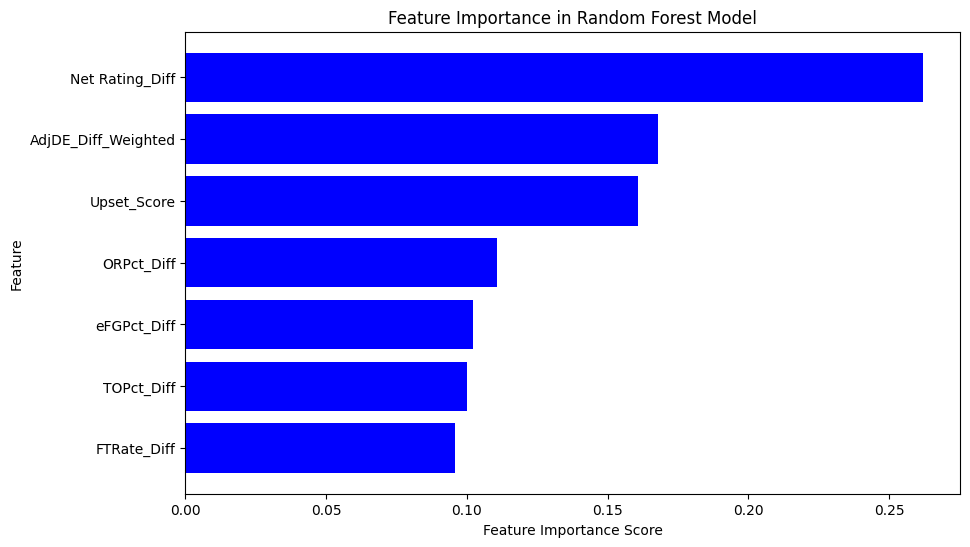

In [202]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importances from the trained model
feature_importances = model.feature_importances_

# Create a DataFrame to display feature importance
importance_df = pd.DataFrame({"Feature": features, "Importance": feature_importances})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Print feature importance
print("\nFeature Importances:")
print(importance_df)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"], importance_df["Importance"], color="blue")
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature")
plt.title("Feature Importance in Random Forest Model")
plt.gca().invert_yaxis()
plt.show()

In [203]:
import joblib

# Save the trained model to a .pkl file
joblib.dump(model, "Model_2.pkl")

print("Model saved as Model_2.pkl")

Model saved as Model_2.pkl


In [204]:
import pandas as pd

# Load the 2025 games file
file_path = "2025 Games (Round of 64).csv"  
data_2025 = pd.read_csv(file_path)

# Ensure missing features are recalculated
data_2025["AdjDE_Diff_Weighted"] = data_2025["AdjDE_Diff"] * 1.6

data_2025["Upset_Score"] = data["Upset_Score"]

# Save the updated 2025 games file for future use
data_2025.to_csv("2025 Games (Round of 64) (Model 2).csv", index=False)

print("\nUpdated 2025 games file saved as '2025 Games (Round of 64) (Model 2).csv' with necessary columns.")


Updated 2025 games file saved as '2025 Games (Round of 64) (Model 2).csv' with necessary columns.


In [205]:

import pandas as pd

# Load 2025 games file
file_path = "2025 Games (Round of 64) (Model 2).csv"  # Update with actual filename
data_2025 = pd.read_csv(file_path)

# Save a copy of all original columns to merge later
extra_columns = data_2025.copy()

# Define the feature columns (these are the only ones needed for prediction)
features = ["Net Rating_Diff", "AdjDE_Diff_Weighted",
            "eFGPct_Diff", "TOPct_Diff", "ORPct_Diff", "FTRate_Diff", "Upset_Score"]

# Select only features for model input
X_2025 = data_2025[features]  # Keep only model training features

print("\nPreview of 2025 Games Data (Only Features for Model Input):")
print(X_2025.head())


Preview of 2025 Games Data (Only Features for Model Input):
   Net Rating_Diff  AdjDE_Diff_Weighted  eFGPct_Diff  TOPct_Diff  ORPct_Diff  \
0             44.2            -27.55632     8.655488    0.124167    6.085104   
1              3.9             -4.37632    -2.401549   -1.579070    5.300557   
2              3.6             -2.47392    -0.480343    6.599155    8.104628   
3             13.0            -18.08080    -7.064508    3.407327    8.416154   
4              2.4             -5.68400    -3.086400   -2.362040   -3.861892   

   FTRate_Diff   Upset_Score  
0     3.655763   6911.642680  
1     6.021685   1391.102790  
2     1.594807  14452.774042  
3     9.715176    793.095130  
4     0.768499    848.172910  


In [206]:
##RUN MODEL FOR ROUND OF 64

# Load the trained model
model = joblib.load("Model_2.pkl")

# Load the 2025 games file
file_path = "2025 Games (Round of 64) (Model 2).csv"  
data_2025 = pd.read_csv(file_path)

# Ensure only the features used in training are selected
X_2025 = data_2025[features]  # Use the existing `features` variable

# Predict game outcomes
data_2025["Predicted_Win"] = model.predict(X_2025)

# Save predictions to a new file
output_file = "Round of 64 Predictions.csv"
data_2025.to_csv(output_file, index=False)

# Display a sample of predictions
print(f"\nPredictions saved to {output_file}")
print("\nSample Predictions:")
print(data_2025.head())


Predictions saved to Round of 64 Predictions.csv

Sample Predictions:
   Season  GameID        Team              VS  TeamID  OpponentID  \
0    2025     100      Auburn   Alabama State    1120        1106   
1    2025     101  Louisville       Creighton    1257        1166   
2    2025     102    Michigan    UC San Diego    1276        1895   
3    2025     103   Texas A&M            Yale    1401        1463   
4    2025     104    Ole Miss  North Carolina    1279        1314   

   Net Rating_Diff  AdjEM_Diff  AdjOE_Diff  AdjDE_Diff  eFGPct_Diff  \
0             44.2     44.2735      27.051    -17.2227     8.655488   
1              3.9      3.9440       1.209     -2.7352    -2.401549   
2              3.6      3.0433       1.497     -1.5462    -0.480343   
3             13.0     13.1372       1.837    -11.3005    -7.064508   
4              2.4      2.5359      -1.016     -3.5525    -3.086400   

   TOPct_Diff  ORPct_Diff  FTRate_Diff  Win  AdjDE_Diff_Weighted  \
0    0.124167    6.

In [ ]:
##RUN MODEL FOR ROUND OF 32

# Load the trained model
model = joblib.load("Model_2.pkl")  # Ensure this is the correct model file

# Load 2025 games file
file_path = "2025 Games (Round of 32).csv"  # Update with your actual filename
data_2025 = pd.read_csv(file_path)

# Save all original columns before modification
original_data = data_2025.copy()

# Define the feature columns (same ones used in training)
features = ["Net Rating_Diff", "AdjOE_Diff", "AdjDE_Diff",
            "eFGPct_Diff", "TOPct_Diff", "ORPct_Diff", "FTRate_Diff"]

# Select only features for model input
X_2025 = data_2025[features]  # Keep only model training features

# Make predictions
original_data["Predicted_Win"] = model.predict(X_2025)

# Save the final file with all columns + predictions
output_file = "predicted_2025_games_with_info.csv"
original_data.to_csv(output_file, index=False)

# Display a sample of the final dataset
print(f"\nPredictions saved to {output_file}")
print("\nSample Predictions with Extra Info:")
print(original_data.head())


Predictions saved to predicted_2025_games_with_info.csv

Sample Predictions with Extra Info:
   Season  GameID       Team              VS  TeamID  OpponentID  \
0    2025     132     Auburn      Louisville    1120        1257   
1    2025     133   Michigan       Texas A&M    1276        1401   
2    2025     134   Ole Miss      Iowa State    1279        1235   
3    2025     135  Marquette  Michigan State    1266        1277   
4    2025     136    Florida           Uconn    1196        1163   

   Net Rating_Diff  AdjEM_Diff  AdjOE_Diff  AdjDE_Diff  eFGPct_Diff  \
0             12.4     12.3920      10.328     -2.0638     2.341799   
1             -1.8     -2.2534       0.506      2.7596     7.475275   
2             -5.0     -4.9276      -1.586      3.3417    -3.477828   
3             -5.9     -5.9786      -0.361      5.6173     0.884577   
4             16.9     16.4940       5.973    -10.5204    -0.383729   

   TOPct_Diff  ORPct_Diff  FTRate_Diff  Predicted_Win  
0   -3.150100 

In [ ]:
##RUN MODEL FOR SWEET 16

# Load the trained model
model = joblib.load("Model_2.pkl")  # Ensure this is the correct model file

# Load 2025 games file
file_path = "2025 Games (Sweet 16).csv"  # Update with your actual filename
data_2025 = pd.read_csv(file_path)

# Save all original columns before modification
original_data = data_2025.copy()

# Define the feature columns (same ones used in training)
features = ["Net Rating_Diff", "AdjEM_Diff", "AdjOE_Diff", "AdjDE_Diff",
            "eFGPct_Diff", "TOPct_Diff", "ORPct_Diff", "FTRate_Diff"]

# Select only features for model input
X_2025 = data_2025[features]  # Keep only model training features

# Make predictions
original_data["Predicted_Win"] = model.predict(X_2025)

# Save the final file with all columns + predictions
output_file = "predicted_2025_games_with_info.csv"
original_data.to_csv(output_file, index=False)

# Display a sample of the final dataset
print(f"\nPredictions saved to {output_file}")
print("\nSample Predictions with Extra Info:")
print(original_data.head())


Predictions saved to predicted_2025_games_with_info.csv

Sample Predictions with Extra Info:
   Season  GameID        Team              VS  TeamID  OpponentID  \
0    2025     132      Auburn       Texas A&M    1120        1401   
1    2025     133  Iowa State  Michigan State    1235        1277   
2    2025     134     Florida        Maryland    1196        1268   
3    2025     135  Texas Tech      St. John's    1403        1385   
4    2025     136        Duke         Arizona    1181        1112   

   Net Rating_Diff  AdjEM_Diff  AdjOE_Diff  AdjDE_Diff  eFGPct_Diff  \
0             10.9     10.9650      12.224      1.2588     8.238830   
1             -0.5     -0.5662       1.427      1.9924     3.411737   
2              9.9      9.4917       9.849      0.3580     1.367445   
3              1.7      1.6803      11.397      9.7171     5.769780   
4             12.5     12.4095       5.432     -6.9774     4.484616   

   TOPct_Diff  ORPct_Diff  FTRate_Diff  Predicted_Win  
0   -4.7

In [ ]:
##RUN MODEL FOR Elite 8

# Load the trained model
model = joblib.load("Model_2.pkl")  # Ensure this is the correct model file

# Load 2025 games file
file_path = "2025 Games (Elite 8).csv"  # Update with your actual filename
data_2025 = pd.read_csv(file_path)

# Save all original columns before modification
original_data = data_2025.copy()

# Define the feature columns (same ones used in training)
features = ["Net Rating_Diff", "AdjEM_Diff", "AdjOE_Diff", "AdjDE_Diff",
            "eFGPct_Diff", "TOPct_Diff", "ORPct_Diff", "FTRate_Diff"]

# Select only features for model input
X_2025 = data_2025[features]  # Keep only model training features

# Make predictions
original_data["Predicted_Win"] = model.predict(X_2025)

# Save the final file with all columns + predictions
output_file = "predicted_2025_games_with_info.csv"
original_data.to_csv(output_file, index=False)

# Display a sample of the final dataset
print(f"\nPredictions saved to {output_file}")
print("\nSample Predictions with Extra Info:")
print(original_data.head())


Predictions saved to predicted_2025_games_with_info.csv

Sample Predictions with Extra Info:
   Season  GameID     Team              VS  TeamID  OpponentID  \
0    2025     132   Auburn  Michigan State    1120        1277   
1    2025     133  Florida      St. John's    1196        1385   
2    2025     134     Duke         Alabama    1181        1104   
3    2025     135  Houston       Tennessee    1222        1397   

   Net Rating_Diff  AdjEM_Diff  AdjOE_Diff  AdjDE_Diff  eFGPct_Diff  \
0              7.5      7.4721      10.449      2.9763     4.561165   
1              9.8      9.4506      14.000      4.5498     5.465553   
2              8.3      8.2454       1.401     -6.8449     1.013231   
3              4.2      4.0053       3.288     -0.7173    -0.120678   

   TOPct_Diff  ORPct_Diff  FTRate_Diff  Predicted_Win  
0   -3.244341   -0.981752    -4.302030            1.0  
1   -0.437073    0.682409     2.008241            1.0  
2   -2.253461    0.461229    -8.032743            1

In [ ]:
##RUN MODEL FOR Final 4

# Load the trained model
model = joblib.load("Model_2.pkl")  # Ensure this is the correct model file

# Load 2025 games file
file_path = "2025 Games (Final 4).csv"  # Update with your actual filename
data_2025 = pd.read_csv(file_path)

# Save all original columns before modification
original_data = data_2025.copy()

# Define the feature columns (same ones used in training)
features = ["Net Rating_Diff", "AdjEM_Diff", "AdjOE_Diff", "AdjDE_Diff",
            "eFGPct_Diff", "TOPct_Diff", "ORPct_Diff", "FTRate_Diff"]

# Select only features for model input
X_2025 = data_2025[features]  # Keep only model training features

# Make predictions
original_data["Predicted_Win"] = model.predict(X_2025)

# Save the final file with all columns + predictions
output_file = "predicted_2025_games_with_info.csv"
original_data.to_csv(output_file, index=False)

# Display a sample of the final dataset
print(f"\nPredictions saved to {output_file}")
print("\nSample Predictions with Extra Info:")
print(original_data.head())


Predictions saved to predicted_2025_games_with_info.csv

Sample Predictions with Extra Info:
   Season  GameID    Team       VS  TeamID  OpponentID  Net Rating_Diff  \
0    2025     132  Auburn  Florida    1120        1196             -1.2   
1    2025     133    Duke  Houston    1181        1222              2.8   

   AdjEM_Diff  AdjOE_Diff  AdjDE_Diff  eFGPct_Diff  TOPct_Diff  ORPct_Diff  \
0     -0.7873       0.567      1.3537     0.560243   -1.755336   -3.667361   
1      2.7079       4.730      2.0217     4.686846   -0.218107   -0.955127   

   FTRate_Diff  Predicted_Win  
0     1.346916            0.0  
1     3.925470            1.0  


In [ ]:
##RUN MODEL FOR NATTY

# Load the trained model
model = joblib.load("Model_2.pkl")  # Ensure this is the correct model file

# Load 2025 games file
file_path = "2025 Games (Natty).csv"  # Update with your actual filename
data_2025 = pd.read_csv(file_path)

# Save all original columns before modification
original_data = data_2025.copy()

# Define the feature columns (same ones used in training)
features = ["Net Rating_Diff", "AdjOE_Diff", "AdjDE_Diff",
            "eFGPct_Diff", "TOPct_Diff", "ORPct_Diff", "FTRate_Diff"]

# Select only features for model input
X_2025 = data_2025[features]  # Keep only model training features

# Make predictions
original_data["Predicted_Win"] = model.predict(X_2025)

# Save the final file with all columns + predictions
output_file = "predicted_2025_games_with_info.csv"
original_data.to_csv(output_file, index=False)

# Display a sample of the final dataset
print(f"\nPredictions saved to {output_file}")
print("\nSample Predictions with Extra Info:")
print(original_data.head())


Predictions saved to predicted_2025_games_with_info.csv

Sample Predictions with Extra Info:
   Season  GameID     Team    VS  TeamID  OpponentID  Net Rating_Diff  \
0    2025     132  Florida  Duke    1196        1181               -2   

   AdjEM_Diff  AdjOE_Diff  AdjDE_Diff  eFGPct_Diff  TOPct_Diff  ORPct_Diff  \
0      -2.326      -0.061      2.2656    -2.211955    0.723045    2.831641   

   FTRate_Diff  Predicted_Win  
0     0.093813            0.0  
